In [182]:
%matplotlib inline

In [183]:
import os
import numpy as np
import pandas as pd
import pickle as pkl
import matplotlib as mpl
import seaborn as sns
from graph_tool.draw import sfdp_layout, graph_draw
from sklearn.metrics import average_precision_score

from helpers import infected_nodes
from graph_helpers import load_graph_by_name

In [192]:
graph = 'grqc'

dataset_id = 'grqc-msi-s0.08-o0.1'
query_path = 'outputs/queries/{}/loop_erased/'.format(dataset_id)
inf_probas_path = 'outputs/inf_probas/{}/loop_erased/'.format(dataset_id)
fig_root_dir = 'figs/why-random-is-good'

In [185]:
if not os.path.exists(fig_dir):
    os.makedirs(fig_dir)

In [186]:
g = load_graph_by_name(graph)
pos = sfdp_layout(g)

In [187]:
def get_performance_scores_over_cascade():
    method_names = ['random', 'pagerank', 'entropy', 'prediction_error']    
    records = []
    for cascade_id in range(96):
        r = {}
        obs, c = pkl.load(open(cascade_path, 'rb'))
        for method in method_names:
            inf_probas_list = pkl.load(open(inf_probas_path + method + '/{}.pkl'.format(cascade_id), 'rb'))
            queries, _ = pkl.load(open(query_path + method + '/{}.pkl'.format(cascade_id), 'rb'))

            known_nodes = set(list(obs) + queries[:num_queries_to_show])
            mask = np.array([(i not in known_nodes) for i in range(len(c))])

            y_true = np.zeros((len(c), ))
            y_true[inf_nodes] = 1

            score = average_precision_score(y_true[mask], inf_probas_list[num_queries_to_show-1][mask])
            r[method] = score
        records.append(r)
    df = pd.DataFrame.from_records(records)
    return df
perf = get_performance_scores_over_cascade()

random_better_df = perf[perf['random'] >= (perf['prediction_error'])]
prederror_better_df = perf[perf['random'] < (perf['prediction_error'])]

# the cascade that random gives the largest peformance advantage over prediction error
random_best_cascade_id = (random_better_df['random'] - random_better_df['prediction_error']).argmax()

# the cascade that prediction gives the largest peformance advantage over random
prederror_best_cascade_id = (random_better_df['random'] - random_better_df['prediction_error']).argmin()

# the cascade that prediction error and random gives the most similar performance
similar_cascade_id = (perf['random'] - perf['prediction_error']).abs().argmin()

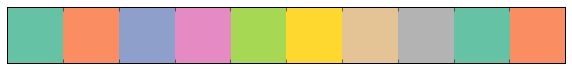

In [188]:
# color related

DEFAULT_COLOR_ID = 7
OBS_COLOR_ID = 5
QUERY_COLOR_ID = 1

pal = sns.color_palette("Set2", 10)
sns.palplot(pal)

def init_node_color(g):
    color = g.new_vertex_property('vector<double>')
    for v in g.vertices():
        color[v] = pal[DEFAULT_COLOR_ID] + (1,)
    return color

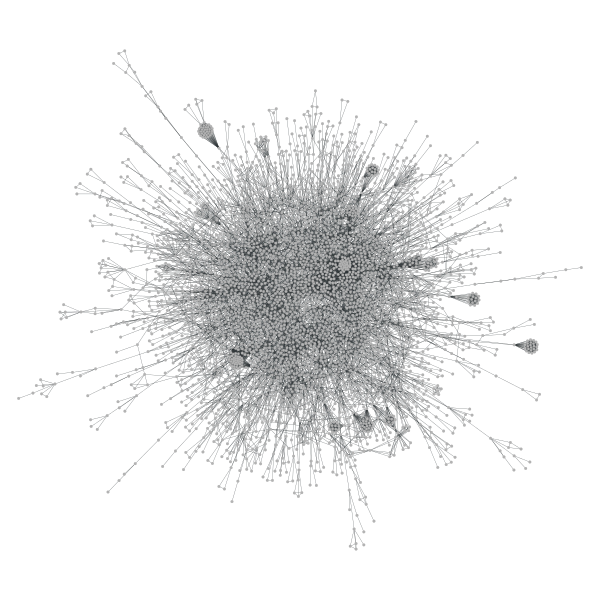

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x7f06fcf5b940, at 0x7f06fc0da470>

In [198]:
color = init_node_color(g)
graph_draw(g, pos=pos, vertex_fill_color=color, output=fig_root_dir+'/graph.pdf')

In [196]:
def illustrate(cascade_id, fig_subdir, num_queries_to_show=25):
    fig_dir = os.path.join(fig_root_dir, fig_subdir)
    if not os.path.exists(fig_dir):
        os.makedirs(fig_dir)
        
    cascade_id = prederror_best_cascade_id
    cascade_path = 'cascade/{}/{}.pkl'.format(dataset_id, cascade_id)

    obs, c = pkl.load(open(cascade_path, 'rb'))
    inf_nodes = infected_nodes(c)

    print('{:.2f} % of the nodes are infected'.format(len(inf_nodes) / g.num_vertices() *100))

    # plot the cascade
    node_color = init_node_color(g)
    for v in (c >= 0).nonzero()[0]:
        node_color[v] = pal[OBS_COLOR_ID] + (1, )

    vertex_size = g.new_vertex_property('int')
    vertex_size.a[c < 0] = 2.5
    vertex_size.a[c >= 0] = 5

    graph_draw(g, pos=pos, vertex_fill_color=node_color, vertex_size=vertex_size,
               output=fig_dir+'/cascade.pdf')
    
    # plot the observation
    node_color = init_node_color(g)
    for v in obs:
        node_color[v] = pal[OBS_COLOR_ID] + (1, )


    vertex_size = g.new_vertex_property('int')
    vertex_size.a = 2.5
    vertex_size.a[obs] = 5

    graph_draw(g, pos=pos,
               vertex_fill_color=node_color,
               vertex_size=vertex_size,
               output=fig_dir+'/observation.pdf') 
    
    
    # plot the queries for each method
    random_queries, _ = pkl.load(open(query_path + 'random/{}.pkl'.format(cascade_id), 'rb'))
    entropy_queries, _ = pkl.load(open(query_path + 'entropy/{}.pkl'.format(cascade_id), 'rb'))
    pagerank_queries, _ = pkl.load(open(query_path + 'pagerank/{}.pkl'.format(cascade_id), 'rb'))
    prederror_queries, _ = pkl.load(open(query_path + 'prediction_error/{}.pkl'.format(cascade_id), 'rb'))    
    
    def show_queries(g, pos, obs, queries, name):
        node_color = init_node_color(g)
        for v in obs:
            node_color[v] = pal[OBS_COLOR_ID] + (1, )
        for v in queries:
            node_color[v] = pal[QUERY_COLOR_ID] + (1,)

        vertex_size = g.new_vertex_property('int')
        vertex_size.a = 2.5
        vertex_size.a[obs] = 10
        vertex_size.a[queries] = 15

        graph_draw(g, pos=pos,
                   vertex_fill_color=node_color,
                   vertex_size=vertex_size,
                   output=fig_dir+'/queries_by_{}.pdf'.format(name))
        
    show_queries(g, pos, obs, random_queries[:num_queries_to_show], 'random')
    show_queries(g, pos, obs, prederror_queries[:num_queries_to_show], 'prediction_error')
    show_queries(g, pos, obs, entropy_queries[:num_queries_to_show], 'entropy')
    show_queries(g, pos, obs, pagerank_queries[:num_queries_to_show], 'pagerank')        

8.59 % of the nodes are infected


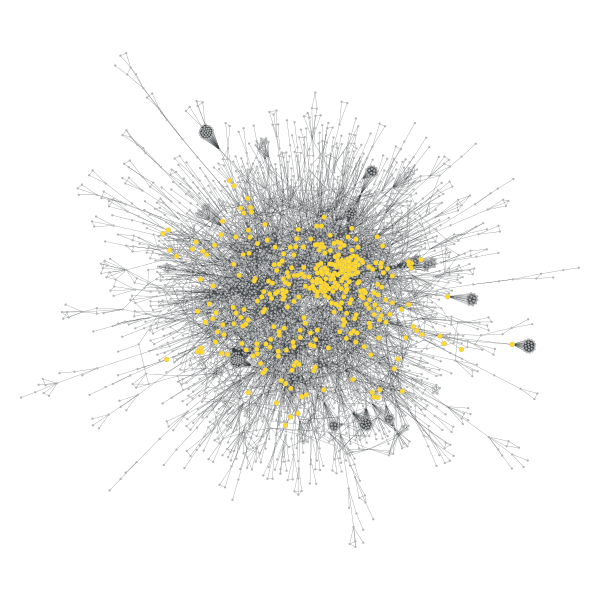

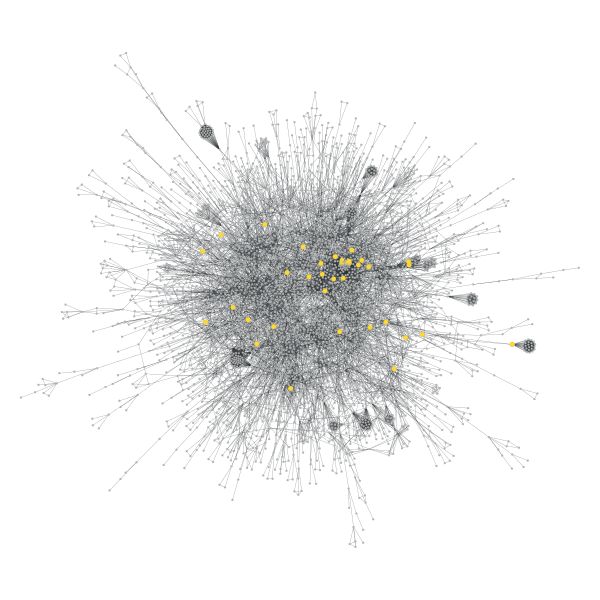

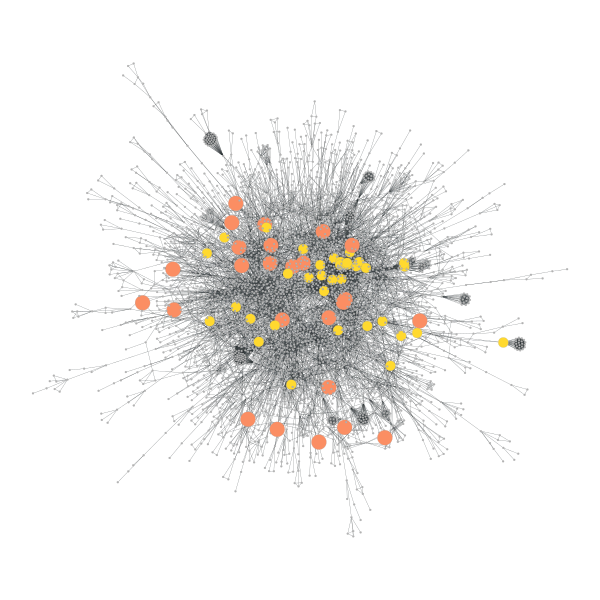

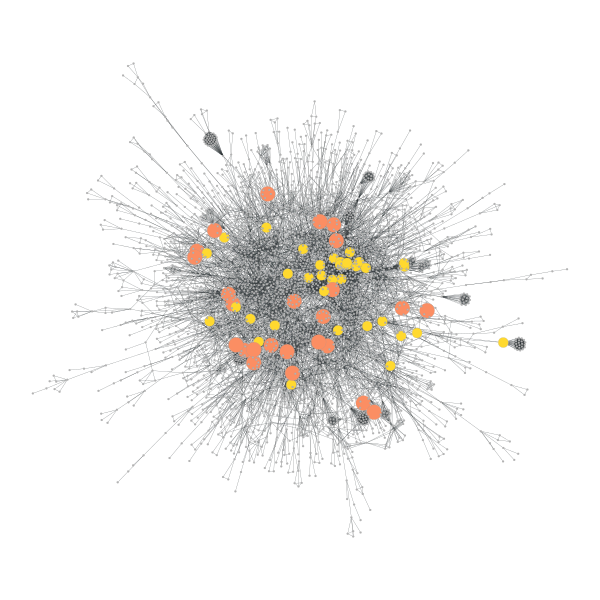

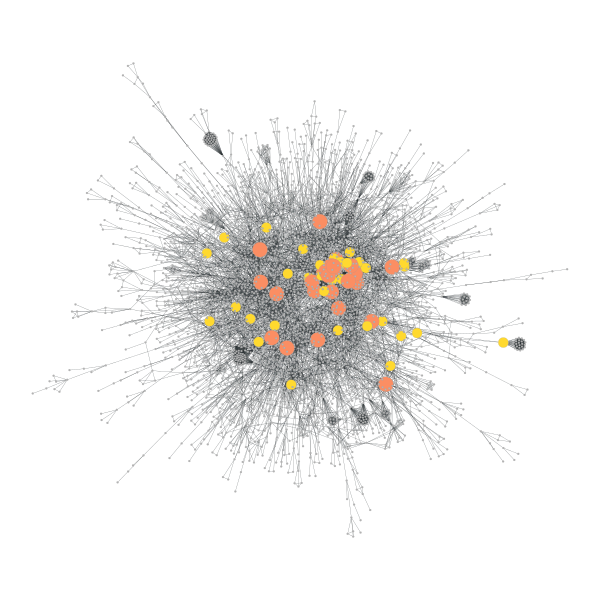

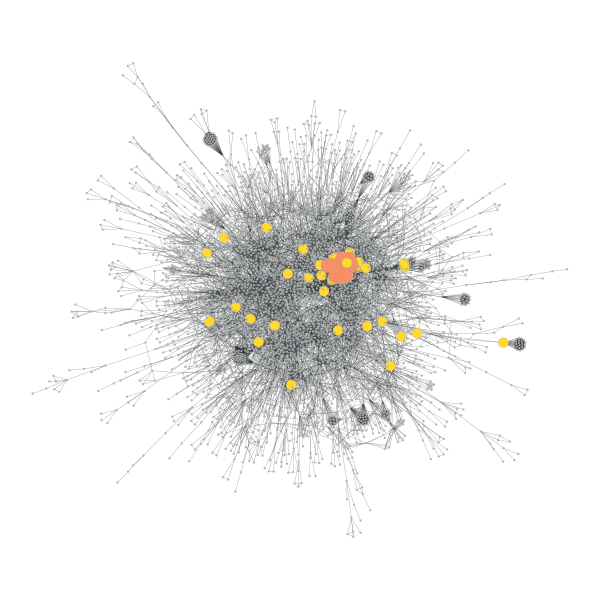

8.59 % of the nodes are infected


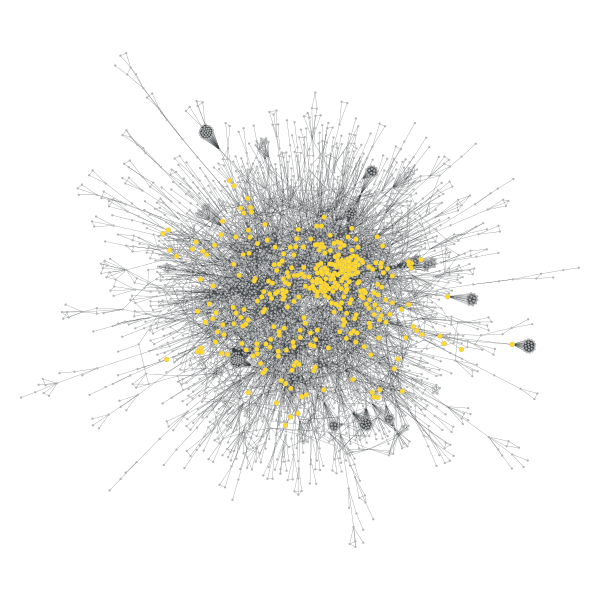

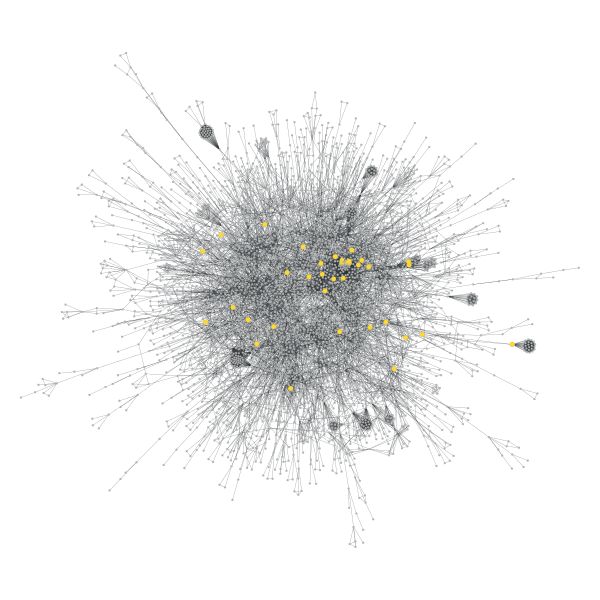

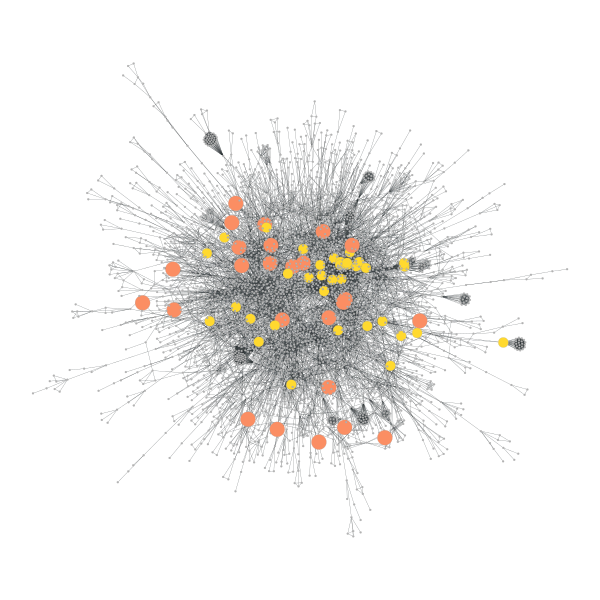

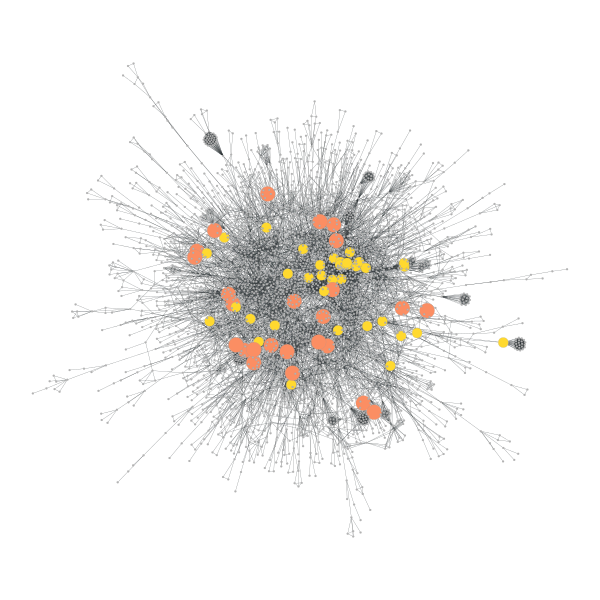

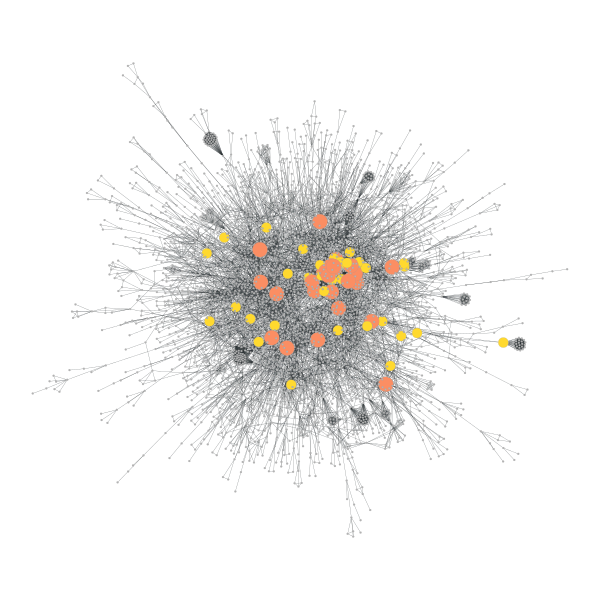

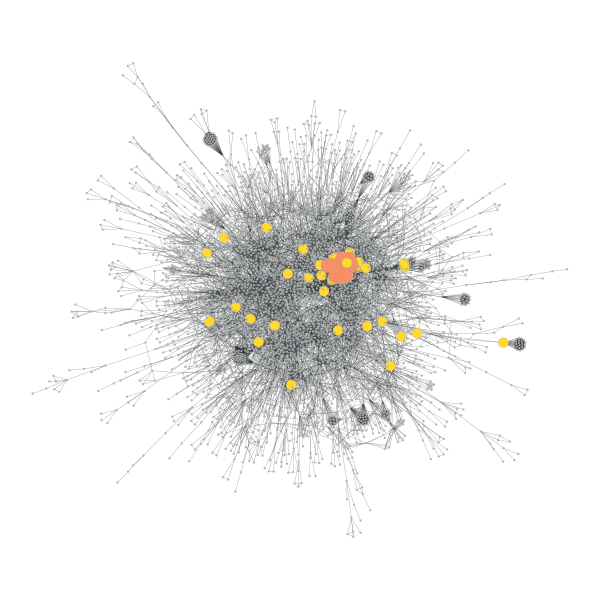

8.59 % of the nodes are infected


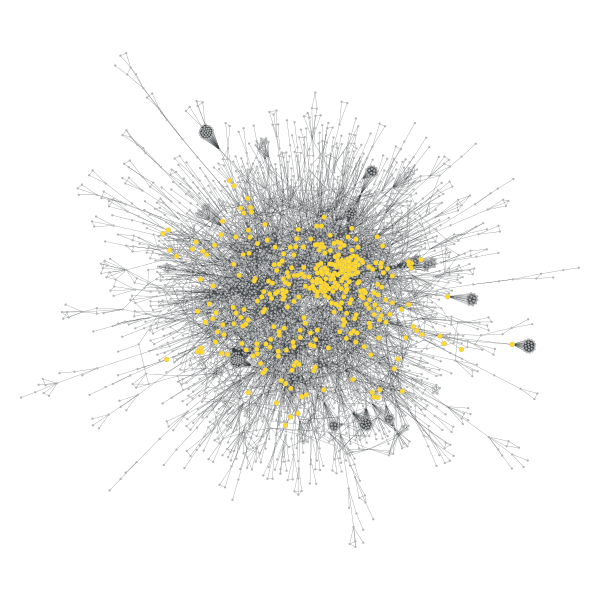

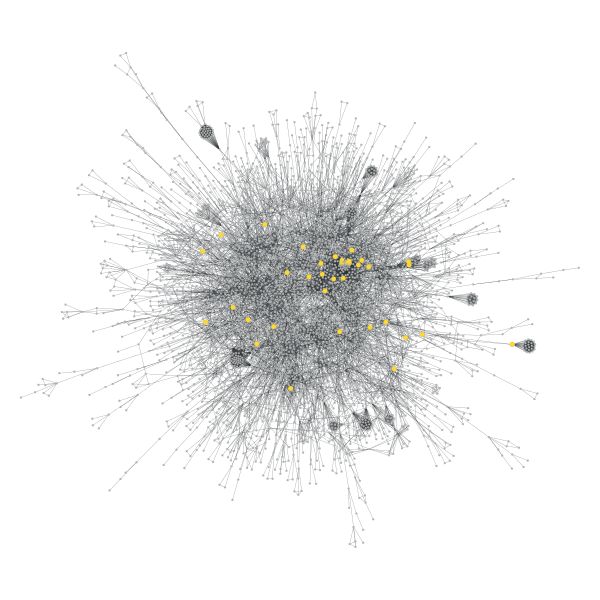

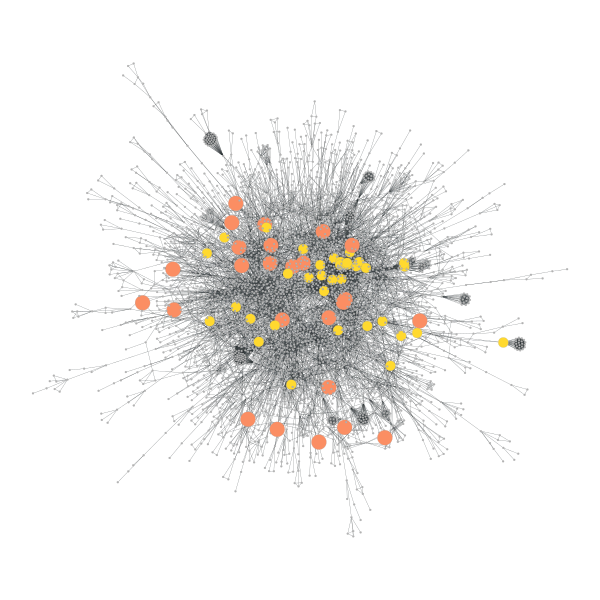

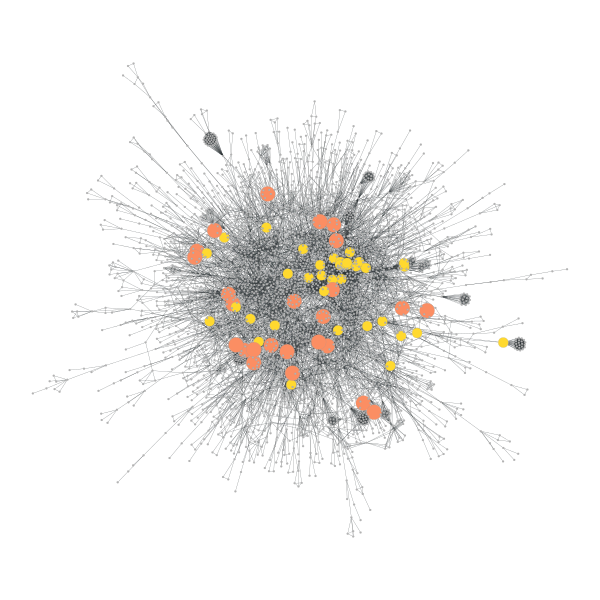

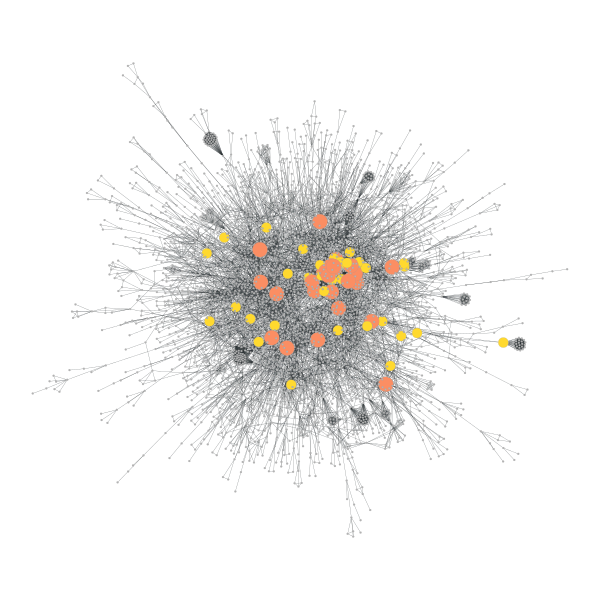

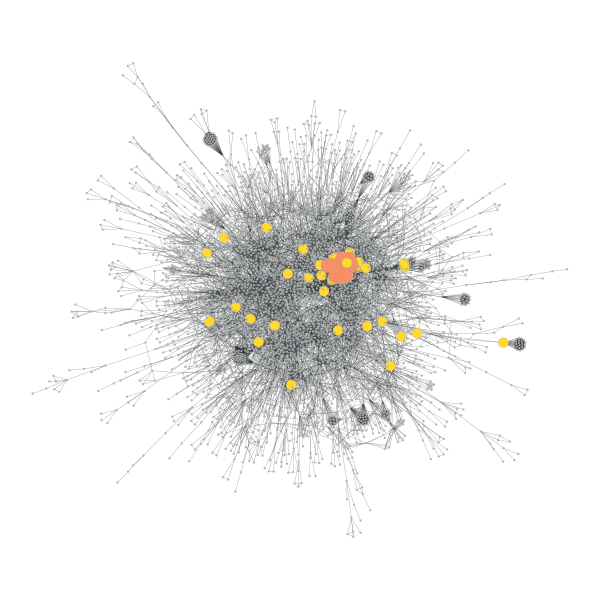

In [197]:
illustrate(random_best_cascade_id, 'random_best')
illustrate(prederror_best_cascade_id, 'prediction_error_best')
illustrate(similar_cascade_id, 'equally_good')

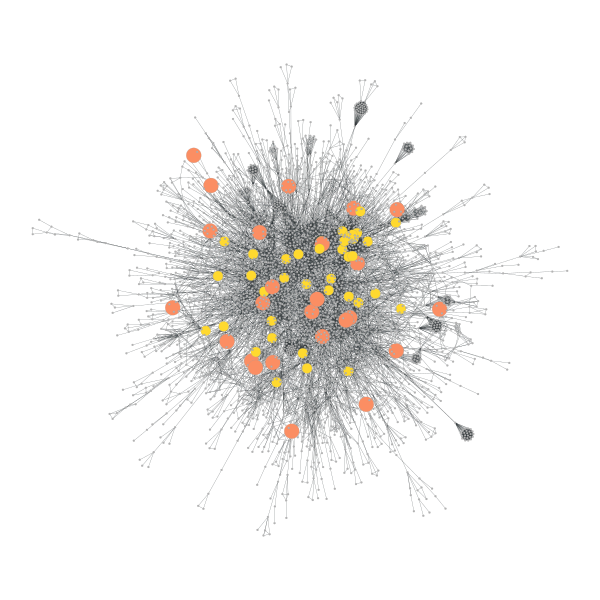

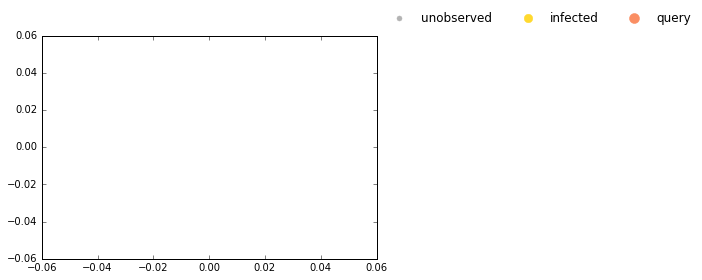

In [179]:
# plot_legend

import matplotlib.pyplot as plt

colors = [pal[DEFAULT_COLOR_ID], pal[OBS_COLOR_ID], pal[QUERY_COLOR_ID]]
sizes = [10, 17, 20]
f = lambda m,c, size: plt.plot([],[],marker=m, color=c, markersize=size, ls="none")[0]
handles = [f(".", colors[i], sizes[i]) for i in range(3)]
labels = ['unobserved', 'infected', 'query']
legend = plt.legend(handles, labels, loc=3, 
                    ncol=3, numpoints=1,
                    bbox_to_anchor=(1,1),
                    framealpha=1, frameon=False)


def export_legend(legend, filename="legend.png"):
    fig  = legend.figure
    fig.canvas.draw()
    bbox  = legend.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    fig.savefig(filename, dpi="figure", bbox_inches=bbox)

export_legend(legend, 'figs/why-random-is-good/lengend.png')
plt.show()